In [4]:
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

# 커스텀 Dataset 클래스
class PreprocessedDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# 이미지 정규화 및 크기 조정
def normalize_and_resize_img(image, label):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(image), label

# 데이터 증강
def augment(image, label):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
    ])
    return transform(image), label

# 원-핫 인코딩
def onehot(label, num_classes=120):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# CutMix
def cutmix(images, labels, alpha=1.0):
    batch_size = images.size(0)
    indices = torch.randperm(batch_size)
    
    lam = torch.distributions.Beta(alpha, alpha).sample()
    
    _, _, H, W = images.shape
    cut_h = int(H * torch.sqrt(1 - lam))
    cut_w = int(W * torch.sqrt(1 - lam))
    
    cx = torch.randint(0, W, (1,)).item()
    cy = torch.randint(0, H, (1,)).item()
    
    x1 = max(0, cx - cut_w // 2)
    x2 = min(W, cx + cut_w // 2)
    y1 = max(0, cy - cut_h // 2)
    y2 = min(H, cy + cut_h // 2)
    
    images[:, :, y1:y2, x1:x2] = images[indices, :, y1:y2, x1:x2]
    
    lam = 1 - ((x2 - x1) * (y2 - y1) / (H * W))
    labels = lam * labels + (1 - lam) * labels[indices]
    
    return images, labels

# MixUp
def mixup(images, labels, alpha=1.0):
    batch_size = images.size(0)
    indices = torch.randperm(batch_size)
    
    lam = torch.distributions.Beta(alpha, alpha).sample()
    
    mixed_images = lam * images + (1 - lam) * images[indices]
    mixed_labels = lam * labels + (1 - lam) * labels[indices]
    
    return mixed_images, mixed_labels

# 데이터셋 적용 함수 (수정됨)
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False, 
                                with_cutmix=False, with_mixup=False, num_classes=120):
    
    print("📦 데이터 로딩 중...")
    data_list = []
    for i in tqdm(dataset.indices, desc="Loading images"):
        img_path, label = dataset.dataset.samples[i]
        img = dataset.dataset.loader(img_path)
        data_list.append((img, label))
    
    print("🔧 정규화 및 리사이즈 적용 중...")
    processed_data = []
    for img, lbl in tqdm(data_list, desc="Normalizing"):
        img_tensor, _ = normalize_and_resize_img(img, lbl)
        processed_data.append((img_tensor, lbl))
    
    # train에서만 augmentation 적용
    if not is_test and with_aug:
        print("✨ 데이터 증강 적용 중...")
        augmented_data = []
        for img, lbl in tqdm(processed_data, desc="Augmenting"):
            # PIL 이미지로 변환 후 augmentation
            img_pil = transforms.ToPILImage()(img)
            img_aug, _ = augment(img_pil, lbl)
            img_tensor = transforms.ToTensor()(img_aug)
            img_tensor = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(img_tensor)
            augmented_data.append((img_tensor, lbl))
        processed_data = augmented_data
    
    # DataLoader 반환 (배치 증강용)
    if not is_test and (with_cutmix or with_mixup):
        print(f"🔄 배치 단위 증강 준비 중... ({'CutMix' if with_cutmix else 'MixUp'})")
        
        # Custom Dataset으로 변환
        custom_dataset = PreprocessedDataset(processed_data)
        dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=2, pin_memory=True)
        
        # 배치 증강 적용 후 결과 저장
        final_batches = []
        desc = "Applying CutMix" if with_cutmix else "Applying MixUp"
        
        for images, labels in tqdm(dataloader, desc=desc):
            labels_onehot = torch.stack([onehot(lbl.item(), num_classes) for lbl in labels])
            
            if with_cutmix:
                images, labels_onehot = cutmix(images, labels_onehot)
            else:  # with_mixup
                images, labels_onehot = mixup(images, labels_onehot)
            
            final_batches.append((images, labels_onehot))
        
        return final_batches
    
    else:
        # 일반 DataLoader 반환
        print("📊 원-핫 인코딩 및 DataLoader 생성 중...")
        
        # 원-핫 인코딩 적용
        final_data = []
        for img, lbl in tqdm(processed_data, desc="One-hot encoding"):
            lbl_onehot = onehot(lbl, num_classes)
            final_data.append((img, lbl_onehot))
        
        custom_dataset = PreprocessedDataset(final_data)
        dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=not is_test,
                              num_workers=2, pin_memory=True)
        
        return dataloader


# ===== 데이터셋 초기화 =====
dataset_dir = "data/Images/"

print("=" * 60)
print("🚀 데이터셋 초기화")
print("=" * 60)

full_dataset = ImageFolder(root=dataset_dir, transform=None)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)
test_size = total_size - train_size

print(f"전체 데이터: {total_size}")
print(f"학습 데이터: {train_size}")
print(f"테스트 데이터: {test_size}")

ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

NUM_CLASSES = len(full_dataset.classes)

# ===== 1. No Augmentation =====
print("\n" + "=" * 60)
print("📋 [1/4] No Augmentation")
print("=" * 60)

df_train_no_aug = apply_normalize_on_dataset(
    ds_train, is_test=False, batch_size=64, 
    with_aug=False, with_cutmix=False, with_mixup=False,
    num_classes=NUM_CLASSES
)

# ===== 2. 기본 Augmentation =====
print("\n" + "=" * 60)
print("🎯 [2/4] 기본 Augmentation")
print("=" * 60)

df_train_basic_aug = apply_normalize_on_dataset(
    ds_train, is_test=False, batch_size=64, 
    with_aug=True, with_cutmix=False, with_mixup=False,
    num_classes=NUM_CLASSES
)

# ===== 3. 기본 + MixUp =====
print("\n" + "=" * 60)
print("🎨 [3/4] 기본 Augmentation + MixUp")
print("=" * 60)

df_train_aug_mixup = apply_normalize_on_dataset(
    ds_train, is_test=False, batch_size=64, 
    with_aug=True, with_cutmix=False, with_mixup=True,
    num_classes=NUM_CLASSES
)

# ===== 4. 기본 + CutMix =====
print("\n" + "=" * 60)
print("✂️ [4/4] 기본 Augmentation + CutMix")
print("=" * 60)

df_train_aug_cutmix = apply_normalize_on_dataset(
    ds_train, is_test=False, batch_size=64, 
    with_aug=True, with_cutmix=True, with_mixup=False,
    num_classes=NUM_CLASSES
)

# ===== Test 데이터 =====
print("\n" + "=" * 60)
print("🧪 Test 데이터 전처리")
print("=" * 60)

df_test = apply_normalize_on_dataset(
    ds_test, is_test=True, batch_size=64,
    num_classes=NUM_CLASSES
)

print("\n" + "=" * 60)
print("📊 최종 요약")
print("=" * 60)
print(f"1. No Augmentation      : {len(df_train_no_aug)} batches")
print(f"2. 기본 Augmentation    : {len(df_train_basic_aug)} batches")
print(f"3. 기본 + MixUp         : {len(df_train_aug_mixup)} batches")
print(f"4. 기본 + CutMix        : {len(df_train_aug_cutmix)} batches")
print(f"5. Test 데이터          : {len(df_test)} batches")
print("=" * 60)

🚀 데이터셋 초기화
전체 데이터: 20580
학습 데이터: 11998
테스트 데이터: 8582

📋 [1/4] No Augmentation
📦 데이터 로딩 중...


Loading images:   0%|          | 0/11998 [00:00<?, ?it/s]

Loading images: 100%|██████████| 11998/11998 [00:18<00:00, 643.94it/s]


🔧 정규화 및 리사이즈 적용 중...


Normalizing: 100%|██████████| 11998/11998 [00:33<00:00, 354.58it/s]


📊 원-핫 인코딩 및 DataLoader 생성 중...


One-hot encoding: 100%|██████████| 11998/11998 [00:00<00:00, 83046.34it/s]



🎯 [2/4] 기본 Augmentation
📦 데이터 로딩 중...


Loading images: 100%|██████████| 11998/11998 [00:17<00:00, 676.72it/s]


🔧 정규화 및 리사이즈 적용 중...


Normalizing: 100%|██████████| 11998/11998 [00:33<00:00, 361.63it/s]


✨ 데이터 증강 적용 중...


Augmenting: 100%|██████████| 11998/11998 [00:37<00:00, 316.29it/s]


📊 원-핫 인코딩 및 DataLoader 생성 중...


One-hot encoding: 100%|██████████| 11998/11998 [00:00<00:00, 33498.52it/s]



🎨 [3/4] 기본 Augmentation + MixUp
📦 데이터 로딩 중...


Loading images: 100%|██████████| 11998/11998 [00:16<00:00, 727.05it/s]


🔧 정규화 및 리사이즈 적용 중...


Normalizing: 100%|██████████| 11998/11998 [00:32<00:00, 371.12it/s]


✨ 데이터 증강 적용 중...


Augmenting: 100%|██████████| 11998/11998 [00:36<00:00, 324.54it/s]


🔄 배치 단위 증강 준비 중... (MixUp)


Applying MixUp: 100%|██████████| 188/188 [00:30<00:00,  6.24it/s]



✂️ [4/4] 기본 Augmentation + CutMix
📦 데이터 로딩 중...


Loading images: 100%|██████████| 11998/11998 [00:17<00:00, 687.09it/s]


🔧 정규화 및 리사이즈 적용 중...


Normalizing: 100%|██████████| 11998/11998 [00:37<00:00, 322.19it/s]


✨ 데이터 증강 적용 중...


Augmenting: 100%|██████████| 11998/11998 [00:36<00:00, 327.08it/s]


🔄 배치 단위 증강 준비 중... (CutMix)


Applying CutMix: 100%|██████████| 188/188 [00:19<00:00,  9.49it/s]



🧪 Test 데이터 전처리
📦 데이터 로딩 중...


Loading images: 100%|██████████| 8582/8582 [00:13<00:00, 645.06it/s]


🔧 정규화 및 리사이즈 적용 중...


Normalizing: 100%|██████████| 8582/8582 [00:23<00:00, 362.63it/s]


📊 원-핫 인코딩 및 DataLoader 생성 중...


One-hot encoding: 100%|██████████| 8582/8582 [00:00<00:00, 76690.15it/s]



📊 최종 요약
1. No Augmentation      : 188 batches
2. 기본 Augmentation    : 188 batches
3. 기본 + MixUp         : 188 batches
4. 기본 + CutMix        : 188 batches
5. Test 데이터          : 135 batches


Using device: cuda
class수 : 120

🚀 Model 1: No Augmentation 학습 시작
📌 Using Hard Label Loss


Epoch 1/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.89it/s, loss=2.4895, acc=36.11%]


Train Loss: 3.6969, Train Accuracy: 36.11%


Epoch 1/20 [Val]: 100%|██████████| 135/135 [00:49<00:00,  2.75it/s, loss=3.0342, acc=68.74%]


Val Loss: 2.2587, Val Accuracy: 68.74%



Epoch 2/20 [Train]: 100%|██████████| 188/188 [01:59<00:00,  1.57it/s, loss=1.1772, acc=75.16%]


Train Loss: 1.6574, Train Accuracy: 75.16%


Epoch 2/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.47it/s, loss=1.8848, acc=79.61%]


Val Loss: 1.1387, Val Accuracy: 79.61%



Epoch 3/20 [Train]: 100%|██████████| 188/188 [00:26<00:00,  7.19it/s, loss=0.9897, acc=82.96%]


Train Loss: 0.9409, Train Accuracy: 82.96%


Epoch 3/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.21it/s, loss=1.5800, acc=82.32%]


Val Loss: 0.8148, Val Accuracy: 82.32%



Epoch 4/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.75it/s, loss=0.8445, acc=87.16%]


Train Loss: 0.6539, Train Accuracy: 87.16%


Epoch 4/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.91it/s, loss=1.1574, acc=83.30%]


Val Loss: 0.6836, Val Accuracy: 83.30%



Epoch 5/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.57it/s, loss=0.5597, acc=90.54%]


Train Loss: 0.4808, Train Accuracy: 90.54%


Epoch 5/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.49it/s, loss=1.2997, acc=84.16%]


Val Loss: 0.6214, Val Accuracy: 84.16%



Epoch 6/20 [Train]: 100%|██████████| 188/188 [00:25<00:00,  7.43it/s, loss=0.4601, acc=92.97%]


Train Loss: 0.3649, Train Accuracy: 92.97%


Epoch 6/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.55it/s, loss=1.2735, acc=84.56%]


Val Loss: 0.5754, Val Accuracy: 84.56%



Epoch 7/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.69it/s, loss=0.5416, acc=94.94%]


Train Loss: 0.2837, Train Accuracy: 94.94%


Epoch 7/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.04it/s, loss=1.1904, acc=84.65%]


Val Loss: 0.5548, Val Accuracy: 84.65%



Epoch 8/20 [Train]: 100%|██████████| 188/188 [00:25<00:00,  7.48it/s, loss=0.3087, acc=96.36%]


Train Loss: 0.2200, Train Accuracy: 96.36%


Epoch 8/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.79it/s, loss=1.2546, acc=84.70%]


Val Loss: 0.5498, Val Accuracy: 84.70%



Epoch 9/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.89it/s, loss=0.3017, acc=97.52%]


Train Loss: 0.1742, Train Accuracy: 97.52%


Epoch 9/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.34it/s, loss=1.4347, acc=84.65%]


Val Loss: 0.5468, Val Accuracy: 84.65%



Epoch 10/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.60it/s, loss=0.2172, acc=98.44%]


Train Loss: 0.1369, Train Accuracy: 98.44%


Epoch 10/20 [Val]: 100%|██████████| 135/135 [00:11<00:00, 12.03it/s, loss=1.4578, acc=84.42%]


Val Loss: 0.5487, Val Accuracy: 84.42%



Epoch 11/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.57it/s, loss=0.1838, acc=98.77%]


Train Loss: 0.1139, Train Accuracy: 98.77%


Epoch 11/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.28it/s, loss=1.4036, acc=84.72%]


Val Loss: 0.5425, Val Accuracy: 84.72%



Epoch 12/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.90it/s, loss=0.1661, acc=99.13%]


Train Loss: 0.0917, Train Accuracy: 99.13%


Epoch 12/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.32it/s, loss=1.3744, acc=84.29%]


Val Loss: 0.5508, Val Accuracy: 84.29%



Epoch 13/20 [Train]: 100%|██████████| 188/188 [00:26<00:00,  7.10it/s, loss=0.1437, acc=99.40%]


Train Loss: 0.0766, Train Accuracy: 99.40%


Epoch 13/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.20it/s, loss=1.3284, acc=84.43%]


Val Loss: 0.5503, Val Accuracy: 84.43%



Epoch 14/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.69it/s, loss=0.0943, acc=99.52%]


Train Loss: 0.0634, Train Accuracy: 99.52%


Epoch 14/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.68it/s, loss=1.3810, acc=84.09%]


Val Loss: 0.5511, Val Accuracy: 84.09%



Epoch 15/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.74it/s, loss=0.0816, acc=99.66%]


Train Loss: 0.0554, Train Accuracy: 99.66%


Epoch 15/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.52it/s, loss=1.3517, acc=84.22%]


Val Loss: 0.5560, Val Accuracy: 84.22%



Epoch 16/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.92it/s, loss=0.1890, acc=99.78%]


Train Loss: 0.0488, Train Accuracy: 99.78%


Epoch 16/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.54it/s, loss=1.4391, acc=84.13%]


Val Loss: 0.5641, Val Accuracy: 84.13%



Epoch 17/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.76it/s, loss=0.0494, acc=99.77%]


Train Loss: 0.0417, Train Accuracy: 99.77%


Epoch 17/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.98it/s, loss=1.3778, acc=84.01%]


Val Loss: 0.5701, Val Accuracy: 84.01%



Epoch 18/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.92it/s, loss=0.1171, acc=99.79%]


Train Loss: 0.0370, Train Accuracy: 99.79%


Epoch 18/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.55it/s, loss=1.2568, acc=84.05%]


Val Loss: 0.5652, Val Accuracy: 84.05%



Epoch 19/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.96it/s, loss=0.0659, acc=99.84%]


Train Loss: 0.0326, Train Accuracy: 99.84%


Epoch 19/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.79it/s, loss=1.3005, acc=83.79%]


Val Loss: 0.5712, Val Accuracy: 83.79%



Epoch 20/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.95it/s, loss=0.0365, acc=99.86%]


Train Loss: 0.0304, Train Accuracy: 99.86%


Epoch 20/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.55it/s, loss=1.2935, acc=83.85%]


Val Loss: 0.5750, Val Accuracy: 83.85%

✅ Model 1: No Augmentation 학습 완료!


🚀 Model 2: Basic Augmentation 학습 시작
📌 Using Hard Label Loss


Epoch 1/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  8.11it/s, loss=4.0128, acc=10.90%]


Train Loss: 4.4331, Train Accuracy: 10.90%


Epoch 1/20 [Val]: 100%|██████████| 135/135 [00:08<00:00, 16.34it/s, loss=3.8681, acc=35.27%]


Val Loss: 3.3476, Val Accuracy: 35.27%



Epoch 2/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.70it/s, loss=2.6260, acc=42.49%]


Train Loss: 3.0177, Train Accuracy: 42.49%


Epoch 2/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.05it/s, loss=2.8934, acc=55.84%]


Val Loss: 2.0965, Val Accuracy: 55.84%



Epoch 3/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.83it/s, loss=1.6206, acc=60.48%]


Train Loss: 1.9461, Train Accuracy: 60.48%


Epoch 3/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.73it/s, loss=2.3986, acc=67.59%]


Val Loss: 1.4485, Val Accuracy: 67.59%



Epoch 4/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.65it/s, loss=1.3858, acc=71.09%]


Train Loss: 1.3567, Train Accuracy: 71.09%


Epoch 4/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 12.92it/s, loss=2.1036, acc=71.94%]


Val Loss: 1.1637, Val Accuracy: 71.94%



Epoch 5/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.89it/s, loss=0.8485, acc=78.78%]


Train Loss: 0.9809, Train Accuracy: 78.78%


Epoch 5/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.49it/s, loss=1.9707, acc=71.60%]


Val Loss: 1.0785, Val Accuracy: 71.60%



Epoch 6/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.94it/s, loss=0.8515, acc=85.48%]


Train Loss: 0.7015, Train Accuracy: 85.48%


Epoch 6/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.20it/s, loss=1.8444, acc=72.72%]


Val Loss: 0.9974, Val Accuracy: 72.72%



Epoch 7/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.61it/s, loss=0.4685, acc=90.37%]


Train Loss: 0.5059, Train Accuracy: 90.37%


Epoch 7/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.43it/s, loss=2.1852, acc=73.15%]


Val Loss: 0.9554, Val Accuracy: 73.15%



Epoch 8/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.95it/s, loss=0.5264, acc=94.21%]


Train Loss: 0.3661, Train Accuracy: 94.21%


Epoch 8/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.82it/s, loss=1.9177, acc=73.02%]


Val Loss: 0.9263, Val Accuracy: 73.02%



Epoch 9/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.87it/s, loss=0.5849, acc=96.73%]


Train Loss: 0.2642, Train Accuracy: 96.73%


Epoch 9/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.58it/s, loss=2.2780, acc=73.04%]


Val Loss: 0.9430, Val Accuracy: 73.04%



Epoch 10/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.93it/s, loss=0.2575, acc=97.97%]


Train Loss: 0.1955, Train Accuracy: 97.97%


Epoch 10/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.43it/s, loss=1.9684, acc=73.09%]


Val Loss: 0.9218, Val Accuracy: 73.09%



Epoch 11/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.81it/s, loss=0.2740, acc=98.86%]


Train Loss: 0.1470, Train Accuracy: 98.86%


Epoch 11/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.82it/s, loss=2.4010, acc=72.84%]


Val Loss: 0.9440, Val Accuracy: 72.84%



Epoch 12/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.92it/s, loss=0.1317, acc=99.46%]


Train Loss: 0.1111, Train Accuracy: 99.46%


Epoch 12/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.58it/s, loss=2.2609, acc=72.31%]


Val Loss: 0.9508, Val Accuracy: 72.31%



Epoch 13/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.74it/s, loss=0.1456, acc=99.66%]


Train Loss: 0.0881, Train Accuracy: 99.66%


Epoch 13/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.40it/s, loss=2.3824, acc=73.48%]


Val Loss: 0.9307, Val Accuracy: 73.48%



Epoch 14/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.70it/s, loss=0.0872, acc=99.81%]


Train Loss: 0.0707, Train Accuracy: 99.81%


Epoch 14/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.05it/s, loss=2.3306, acc=72.19%]


Val Loss: 0.9634, Val Accuracy: 72.19%



Epoch 15/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.65it/s, loss=0.0833, acc=99.89%]


Train Loss: 0.0578, Train Accuracy: 99.89%


Epoch 15/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.47it/s, loss=2.3780, acc=72.52%]


Val Loss: 0.9512, Val Accuracy: 72.52%



Epoch 16/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.90it/s, loss=0.0656, acc=99.94%]


Train Loss: 0.0493, Train Accuracy: 99.94%


Epoch 16/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.19it/s, loss=2.2887, acc=72.51%]


Val Loss: 0.9476, Val Accuracy: 72.51%



Epoch 17/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.81it/s, loss=0.0927, acc=99.92%]


Train Loss: 0.0431, Train Accuracy: 99.92%


Epoch 17/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.48it/s, loss=2.4190, acc=72.30%]


Val Loss: 0.9781, Val Accuracy: 72.30%



Epoch 18/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.81it/s, loss=0.0423, acc=99.95%]


Train Loss: 0.0364, Train Accuracy: 99.95%


Epoch 18/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.59it/s, loss=2.3649, acc=72.59%]


Val Loss: 0.9632, Val Accuracy: 72.59%



Epoch 19/20 [Train]: 100%|██████████| 188/188 [00:23<00:00,  7.84it/s, loss=0.0773, acc=99.96%]


Train Loss: 0.0325, Train Accuracy: 99.96%


Epoch 19/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 12.56it/s, loss=2.4229, acc=71.66%]


Val Loss: 0.9939, Val Accuracy: 71.66%



Epoch 20/20 [Train]: 100%|██████████| 188/188 [00:24<00:00,  7.70it/s, loss=0.0524, acc=99.95%]


Train Loss: 0.0299, Train Accuracy: 99.95%


Epoch 20/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.39it/s, loss=2.6707, acc=71.86%]


Val Loss: 0.9910, Val Accuracy: 71.86%

✅ Model 2: Basic Augmentation 학습 완료!


🚀 Model 3: Basic + MixUp 학습 시작
📌 Using Soft Label Loss


Epoch 1/20 [Train]: 100%|██████████| 188/188 [00:22<00:00,  8.34it/s, loss=4.4318, acc=4.16%]


Train Loss: 4.6905, Train Accuracy: 4.16%


Epoch 1/20 [Val]: 100%|██████████| 135/135 [00:08<00:00, 16.27it/s, loss=4.5917, acc=18.64%]


Val Loss: 4.1996, Val Accuracy: 18.64%



Epoch 2/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.07it/s, loss=3.5273, acc=19.87%]


Train Loss: 4.1803, Train Accuracy: 19.87%


Epoch 2/20 [Val]: 100%|██████████| 135/135 [00:08<00:00, 15.29it/s, loss=3.7575, acc=35.17%]


Val Loss: 3.0713, Val Accuracy: 35.17%



Epoch 3/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.04it/s, loss=2.7928, acc=33.85%]


Train Loss: 3.6158, Train Accuracy: 33.85%


Epoch 3/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 12.65it/s, loss=3.2680, acc=46.33%]


Val Loss: 2.4258, Val Accuracy: 46.33%



Epoch 4/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.03it/s, loss=2.2984, acc=44.32%]


Train Loss: 3.1913, Train Accuracy: 44.32%


Epoch 4/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.81it/s, loss=2.8761, acc=53.94%]


Val Loss: 2.0325, Val Accuracy: 53.94%



Epoch 5/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.06it/s, loss=1.9341, acc=53.74%]


Train Loss: 2.8701, Train Accuracy: 53.74%


Epoch 5/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.75it/s, loss=2.6357, acc=58.52%]


Val Loss: 1.7978, Val Accuracy: 58.52%



Epoch 6/20 [Train]: 100%|██████████| 188/188 [00:19<00:00,  9.75it/s, loss=1.6703, acc=62.13%]


Train Loss: 2.6018, Train Accuracy: 62.13%


Epoch 6/20 [Val]: 100%|██████████| 135/135 [00:08<00:00, 15.20it/s, loss=2.4939, acc=61.27%]


Val Loss: 1.6597, Val Accuracy: 61.27%



Epoch 7/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.02it/s, loss=1.4664, acc=69.73%]


Train Loss: 2.3656, Train Accuracy: 69.73%


Epoch 7/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.54it/s, loss=2.4100, acc=62.79%]


Val Loss: 1.5754, Val Accuracy: 62.79%



Epoch 8/20 [Train]: 100%|██████████| 188/188 [00:18<00:00,  9.98it/s, loss=1.3098, acc=76.62%]


Train Loss: 2.1561, Train Accuracy: 76.62%


Epoch 8/20 [Val]: 100%|██████████| 135/135 [00:08<00:00, 15.05it/s, loss=2.3826, acc=63.64%]


Val Loss: 1.5300, Val Accuracy: 63.64%



Epoch 9/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.05it/s, loss=1.2008, acc=82.37%]


Train Loss: 1.9713, Train Accuracy: 82.37%


Epoch 9/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.80it/s, loss=2.3663, acc=63.52%]


Val Loss: 1.5090, Val Accuracy: 63.52%



Epoch 10/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.03it/s, loss=1.1280, acc=86.36%]


Train Loss: 1.8126, Train Accuracy: 86.36%


Epoch 10/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.90it/s, loss=2.4049, acc=63.49%]


Val Loss: 1.4844, Val Accuracy: 63.49%



Epoch 11/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.03it/s, loss=1.0751, acc=88.91%]


Train Loss: 1.6845, Train Accuracy: 88.91%


Epoch 11/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.77it/s, loss=2.4416, acc=63.34%]


Val Loss: 1.4869, Val Accuracy: 63.34%



Epoch 12/20 [Train]: 100%|██████████| 188/188 [00:19<00:00,  9.88it/s, loss=1.0391, acc=89.73%]


Train Loss: 1.5881, Train Accuracy: 89.73%


Epoch 12/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.09it/s, loss=2.4876, acc=63.06%]


Val Loss: 1.4817, Val Accuracy: 63.06%



Epoch 13/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.03it/s, loss=1.0080, acc=90.04%]


Train Loss: 1.5229, Train Accuracy: 90.04%


Epoch 13/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.48it/s, loss=2.4749, acc=62.46%]


Val Loss: 1.5024, Val Accuracy: 62.46%



Epoch 14/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.04it/s, loss=0.9833, acc=89.25%]


Train Loss: 1.4537, Train Accuracy: 89.25%


Epoch 14/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.21it/s, loss=2.5722, acc=61.65%]


Val Loss: 1.5266, Val Accuracy: 61.65%



Epoch 15/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.06it/s, loss=0.9588, acc=89.77%]


Train Loss: 1.3894, Train Accuracy: 89.77%


Epoch 15/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.85it/s, loss=2.4198, acc=61.73%]


Val Loss: 1.5216, Val Accuracy: 61.73%



Epoch 16/20 [Train]: 100%|██████████| 188/188 [00:18<00:00,  9.93it/s, loss=0.9406, acc=88.71%]


Train Loss: 1.3297, Train Accuracy: 88.71%


Epoch 16/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.97it/s, loss=2.6742, acc=61.33%]


Val Loss: 1.5377, Val Accuracy: 61.33%



Epoch 17/20 [Train]: 100%|██████████| 188/188 [00:18<00:00,  9.97it/s, loss=0.9209, acc=88.91%]


Train Loss: 1.2818, Train Accuracy: 88.91%


Epoch 17/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.20it/s, loss=2.5936, acc=60.65%]


Val Loss: 1.5633, Val Accuracy: 60.65%



Epoch 18/20 [Train]: 100%|██████████| 188/188 [02:14<00:00,  1.40it/s, loss=0.8970, acc=88.11%]


Train Loss: 1.2367, Train Accuracy: 88.11%


Epoch 18/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.78it/s, loss=2.6384, acc=61.34%]


Val Loss: 1.5345, Val Accuracy: 61.34%



Epoch 19/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.03it/s, loss=0.8709, acc=88.06%]


Train Loss: 1.2021, Train Accuracy: 88.06%


Epoch 19/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.11it/s, loss=2.8987, acc=60.78%]


Val Loss: 1.5796, Val Accuracy: 60.78%



Epoch 20/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.05it/s, loss=0.8596, acc=87.46%]


Train Loss: 1.1647, Train Accuracy: 87.46%


Epoch 20/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 12.69it/s, loss=2.5435, acc=60.16%]


Val Loss: 1.5900, Val Accuracy: 60.16%

✅ Model 3: Basic + MixUp 학습 완료!


🚀 Model 4: Basic + CutMix 학습 시작
📌 Using Soft Label Loss


Epoch 1/20 [Train]: 100%|██████████| 188/188 [00:18<00:00,  9.94it/s, loss=4.5515, acc=3.75%]


Train Loss: 4.7101, Train Accuracy: 3.75%


Epoch 1/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.91it/s, loss=4.5706, acc=15.88%]


Val Loss: 4.2325, Val Accuracy: 15.88%



Epoch 2/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.11it/s, loss=4.0472, acc=17.90%]


Train Loss: 4.2518, Train Accuracy: 17.90%


Epoch 2/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.40it/s, loss=3.7836, acc=34.92%]


Val Loss: 3.0940, Val Accuracy: 34.92%



Epoch 3/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.07it/s, loss=3.6103, acc=30.77%]


Train Loss: 3.7214, Train Accuracy: 30.77%


Epoch 3/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.32it/s, loss=3.2484, acc=49.34%]


Val Loss: 2.3747, Val Accuracy: 49.34%



Epoch 4/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.07it/s, loss=3.2790, acc=40.12%]


Train Loss: 3.3038, Train Accuracy: 40.12%


Epoch 4/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.42it/s, loss=2.8906, acc=59.26%]


Val Loss: 1.9255, Val Accuracy: 59.26%



Epoch 5/20 [Train]: 100%|██████████| 188/188 [00:18<00:00,  9.98it/s, loss=2.9990, acc=48.75%]


Train Loss: 2.9854, Train Accuracy: 48.75%


Epoch 5/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.15it/s, loss=2.6949, acc=63.99%]


Val Loss: 1.6536, Val Accuracy: 63.99%



Epoch 6/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.08it/s, loss=2.7438, acc=56.73%]


Train Loss: 2.7227, Train Accuracy: 56.73%


Epoch 6/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.73it/s, loss=2.5725, acc=66.70%]


Val Loss: 1.4936, Val Accuracy: 66.70%



Epoch 7/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.10it/s, loss=2.5087, acc=63.94%]


Train Loss: 2.4922, Train Accuracy: 63.94%


Epoch 7/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.44it/s, loss=2.5076, acc=67.92%]


Val Loss: 1.3978, Val Accuracy: 67.92%



Epoch 8/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.08it/s, loss=2.2999, acc=70.86%]


Train Loss: 2.2854, Train Accuracy: 70.86%


Epoch 8/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.22it/s, loss=2.4868, acc=68.60%]


Val Loss: 1.3443, Val Accuracy: 68.60%



Epoch 9/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.00it/s, loss=2.1164, acc=76.80%]


Train Loss: 2.0995, Train Accuracy: 76.80%


Epoch 9/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.86it/s, loss=2.4498, acc=69.20%]


Val Loss: 1.3041, Val Accuracy: 69.20%



Epoch 10/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.08it/s, loss=1.9489, acc=81.98%]


Train Loss: 1.9337, Train Accuracy: 81.98%


Epoch 10/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.80it/s, loss=2.4581, acc=69.73%]


Val Loss: 1.2775, Val Accuracy: 69.73%



Epoch 11/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.11it/s, loss=1.7954, acc=85.81%]


Train Loss: 1.7865, Train Accuracy: 85.81%


Epoch 11/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.53it/s, loss=2.4578, acc=69.95%]


Val Loss: 1.2651, Val Accuracy: 69.95%



Epoch 12/20 [Train]: 100%|██████████| 188/188 [00:18<00:00,  9.96it/s, loss=1.6637, acc=88.72%]


Train Loss: 1.6570, Train Accuracy: 88.72%


Epoch 12/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.78it/s, loss=2.4577, acc=69.39%]


Val Loss: 1.2666, Val Accuracy: 69.39%



Epoch 13/20 [Train]: 100%|██████████| 188/188 [00:18<00:00,  9.90it/s, loss=1.6329, acc=90.71%]


Train Loss: 1.5444, Train Accuracy: 90.71%


Epoch 13/20 [Val]: 100%|██████████| 135/135 [00:12<00:00, 11.06it/s, loss=2.3688, acc=69.34%]


Val Loss: 1.2652, Val Accuracy: 69.34%



Epoch 14/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.08it/s, loss=1.5556, acc=91.89%]


Train Loss: 1.4481, Train Accuracy: 91.89%


Epoch 14/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 13.52it/s, loss=2.4131, acc=68.27%]


Val Loss: 1.2918, Val Accuracy: 68.27%



Epoch 15/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.08it/s, loss=1.5877, acc=91.77%]


Train Loss: 1.3769, Train Accuracy: 91.77%


Epoch 15/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.66it/s, loss=2.3700, acc=68.55%]


Val Loss: 1.2848, Val Accuracy: 68.55%



Epoch 16/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.09it/s, loss=1.4251, acc=90.84%]


Train Loss: 1.3261, Train Accuracy: 90.84%


Epoch 16/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.24it/s, loss=2.4240, acc=67.32%]


Val Loss: 1.3293, Val Accuracy: 67.32%



Epoch 17/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.09it/s, loss=1.3792, acc=89.56%]


Train Loss: 1.2821, Train Accuracy: 89.56%


Epoch 17/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.11it/s, loss=2.3962, acc=67.93%]


Val Loss: 1.2959, Val Accuracy: 67.93%



Epoch 18/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.05it/s, loss=1.4103, acc=89.70%]


Train Loss: 1.2348, Train Accuracy: 89.70%


Epoch 18/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 13.19it/s, loss=2.5346, acc=66.76%]


Val Loss: 1.3060, Val Accuracy: 66.76%



Epoch 19/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.09it/s, loss=1.2623, acc=88.68%]


Train Loss: 1.1852, Train Accuracy: 88.68%


Epoch 19/20 [Val]: 100%|██████████| 135/135 [00:09<00:00, 14.59it/s, loss=2.7026, acc=67.69%]


Val Loss: 1.2874, Val Accuracy: 67.69%



Epoch 20/20 [Train]: 100%|██████████| 188/188 [00:18<00:00, 10.09it/s, loss=1.3225, acc=89.21%]


Train Loss: 1.1456, Train Accuracy: 89.21%


Epoch 20/20 [Val]: 100%|██████████| 135/135 [00:10<00:00, 12.90it/s, loss=2.4274, acc=67.13%]


Val Loss: 1.3027, Val Accuracy: 67.13%

✅ Model 4: Basic + CutMix 학습 완료!


📊 결과 시각화


/tmp/ipykernel_3390727/793872399.py:218: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:218: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:218: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:218: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:218: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:218: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:219: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Deja

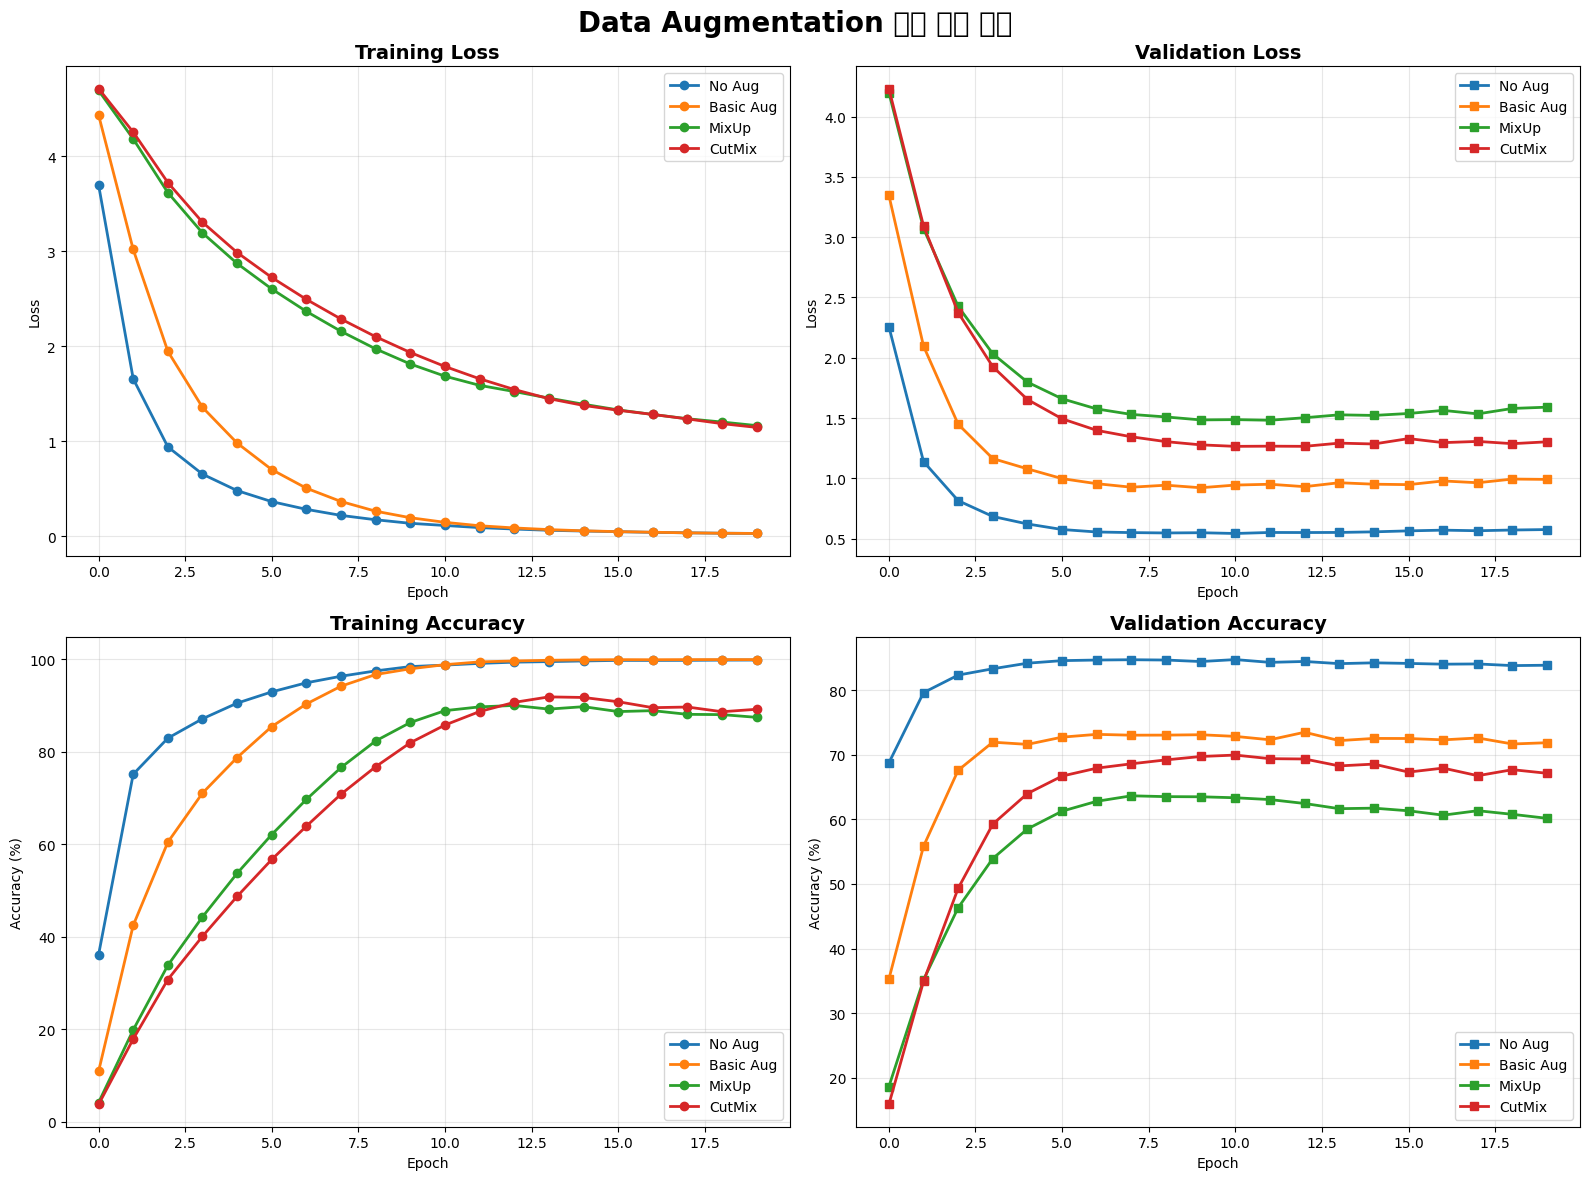

/tmp/ipykernel_3390727/793872399.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=15)
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning


📈 최종 성능 비교 (마지막 Epoch)

No Aug:
  Train Acc: 99.86% | Val Acc: 83.85%
  Train Loss: 0.0304 | Val Loss: 0.5750

Basic Aug:
  Train Acc: 99.95% | Val Acc: 71.86%
  Train Loss: 0.0299 | Val Loss: 0.9910

MixUp:
  Train Acc: 87.46% | Val Acc: 60.16%
  Train Loss: 1.1647 | Val Loss: 1.5900

CutMix:
  Train Acc: 89.21% | Val Acc: 67.13%
  Train Loss: 1.1456 | Val Loss: 1.3027


/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 45230 (\N{HANGUL SYLLABLE NAJ}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 51012 (\N{HANGUL SYLLABLE EUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 47197 (\N{HANGUL SYLLABLE ROG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 51339 (\N{HANGUL SYLLABLE JOH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:280: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3390727/793872399.py:281: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu

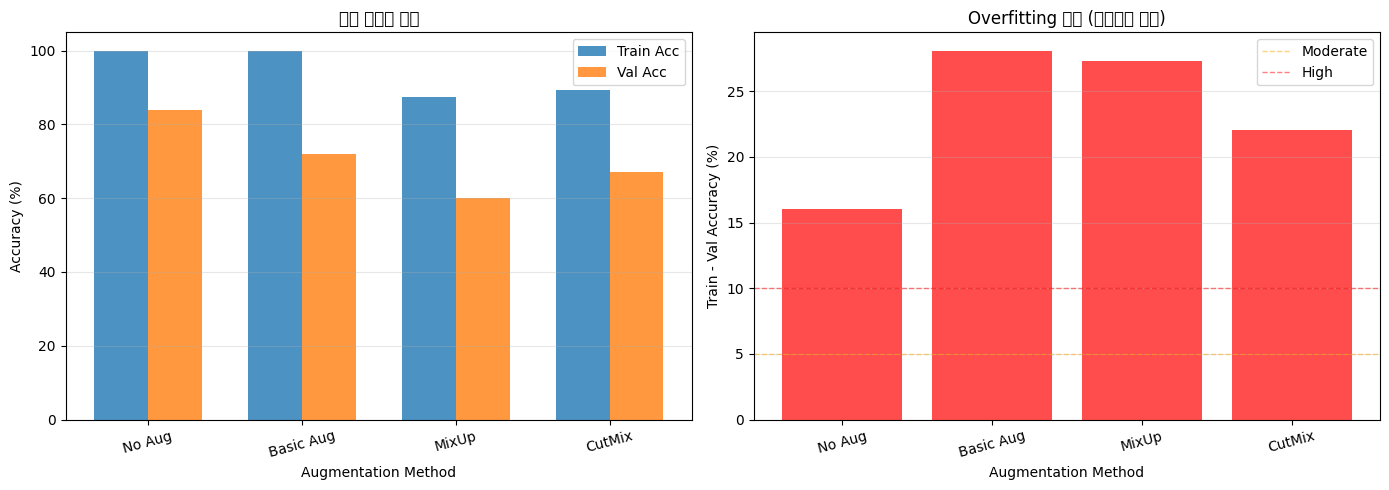


✅ 모든 실험 완료!


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm.auto import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# GPU 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

num_classes = NUM_CLASSES
print("class수 :", num_classes)

# ===== 모델 정의 =====
def create_resnet50_model(num_classes):
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
    return resnet50

# 1. No Augmentation 
resnet50_no_aug = create_resnet50_model(num_classes)

# 2. 기본 Augmentation
resnet50_aug = create_resnet50_model(num_classes)

# 3. 기본 + MixUp
resnet50_mixup = create_resnet50_model(num_classes)

# 4. 기본 + CutMix
resnet50_cutmix = create_resnet50_model(num_classes)

EPOCH = 20
criterion = nn.CrossEntropyLoss()

# ===== 학습 함수 =====
def train(model, train_loader, test_loader, epochs, use_soft_label=False, model_name="Model"):
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    print(f"\n{'='*60}")
    print(f"🚀 {model_name} 학습 시작")
    if use_soft_label:
        print(f"📌 Using Soft Label Loss")
    else:
        print(f"📌 Using Hard Label Loss")
    print(f"{'='*60}")

    for epoch in range(epochs):
        # ===== Training Phase =====
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
            # Loss 계산
            if use_soft_label:
                # Soft label용 (MixUp/CutMix)
                loss = -(labels * F.log_softmax(outputs, dim=1)).sum(dim=1).mean()
            else:
                # Hard label용
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            _, labels_class = labels.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels_class).sum().item()
            
            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })

        epoch_train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        history['train_loss'].append(epoch_train_loss)
        history['train_accuracy'].append(train_acc)
        
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

        # ===== Validation Phase =====
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for images, labels in test_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                _, labels_class = labels.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels_class).sum().item()
                
                test_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100. * correct / total:.2f}%'
                })

        epoch_val_loss = val_loss / len(test_loader)
        val_acc = 100. * correct / total
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(val_acc)
        
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")
    
    print(f"✅ {model_name} 학습 완료!\n")
    return history


# ===== 모델 학습 =====

# 1. No Augmentation
history_resnet50_no_aug = train(
    resnet50_no_aug, df_train_no_aug, df_test, EPOCH, 
    use_soft_label=False, model_name="Model 1: No Augmentation"
)

# 2. Basic Augmentation
history_resnet50_aug = train(
    resnet50_aug, df_train_basic_aug, df_test, EPOCH, 
    use_soft_label=False, model_name="Model 2: Basic Augmentation"
)

# 3. Basic + MixUp
history_resnet50_mixup = train(
    resnet50_mixup, df_train_aug_mixup, df_test, EPOCH, 
    use_soft_label=True, model_name="Model 3: Basic + MixUp"
)

# 4. Basic + CutMix
history_resnet50_cutmix = train(
    resnet50_cutmix, df_train_aug_cutmix, df_test, EPOCH, 
    use_soft_label=True, model_name="Model 4: Basic + CutMix"
)


# ===== 시각화 =====
print("\n" + "=" * 60)
print("📊 결과 시각화")
print("=" * 60)

histories = {
    'No Aug': history_resnet50_no_aug,
    'Basic Aug': history_resnet50_aug,
    'MixUp': history_resnet50_mixup,
    'CutMix': history_resnet50_cutmix
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Data Augmentation 비교 실험 결과', fontsize=20, fontweight='bold')

# 1. Training Loss
ax = axes[0, 0]
for name, history in histories.items():
    ax.plot(history['train_loss'], marker='o', label=name, linewidth=2)
ax.set_title('Training Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Validation Loss
ax = axes[0, 1]
for name, history in histories.items():
    ax.plot(history['val_loss'], marker='s', label=name, linewidth=2)
ax.set_title('Validation Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Training Accuracy
ax = axes[1, 0]
for name, history in histories.items():
    ax.plot(history['train_accuracy'], marker='o', label=name, linewidth=2)
ax.set_title('Training Accuracy', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Validation Accuracy
ax = axes[1, 1]
for name, history in histories.items():
    ax.plot(history['val_accuracy'], marker='s', label=name, linewidth=2)
ax.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('augmentation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== 최종 성능 비교 =====
print("\n" + "=" * 60)
print("📈 최종 성능 비교 (마지막 Epoch)")
print("=" * 60)

comparison_data = []
for name, history in histories.items():
    final_train_acc = history['train_accuracy'][-1]
    final_val_acc = history['val_accuracy'][-1]
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    
    print(f"\n{name}:")
    print(f"  Train Acc: {final_train_acc:.2f}% | Val Acc: {final_val_acc:.2f}%")
    print(f"  Train Loss: {final_train_loss:.4f} | Val Loss: {final_val_loss:.4f}")
    
    comparison_data.append({
        'name': name,
        'train_acc': final_train_acc,
        'val_acc': final_val_acc,
        'overfitting': final_train_acc - final_val_acc
    })

# 막대 그래프로 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

names = [d['name'] for d in comparison_data]
train_accs = [d['train_acc'] for d in comparison_data]
val_accs = [d['val_acc'] for d in comparison_data]
overfitting_gaps = [d['overfitting'] for d in comparison_data]

# 정확도 비교
ax = axes[0]
x = np.arange(len(names))
width = 0.35
ax.bar(x - width/2, train_accs, width, label='Train Acc', alpha=0.8)
ax.bar(x + width/2, val_accs, width, label='Val Acc', alpha=0.8)
ax.set_xlabel('Augmentation Method')
ax.set_ylabel('Accuracy (%)')
ax.set_title('최종 정확도 비교')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=15)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Overfitting 정도 비교
ax = axes[1]
colors = ['red' if gap > 10 else 'orange' if gap > 5 else 'green' for gap in overfitting_gaps]
ax.bar(names, overfitting_gaps, color=colors, alpha=0.7)
ax.set_xlabel('Augmentation Method')
ax.set_ylabel('Train - Val Accuracy (%)')
ax.set_title('Overfitting 정도 (낮을수록 좋음)')
ax.set_xticklabels(names, rotation=15)
ax.axhline(y=5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Moderate')
ax.axhline(y=10, color='red', linestyle='--', linewidth=1, alpha=0.5, label='High')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("✅ 모든 실험 완료!")
print("=" * 60)

### 실험결과 요약
20 epoch 학습 후 네 가지 augmentation 기법의 최종 성능은 다음과 같다. (최대 20epoch까지밖에 학습을 못시켰습니다 ㅠㅠ)

- No Augmentation이 validation accuracy 83.85%로 가장 높은 성능을 보였으며, train accuracy 99.86%와의 차이는 16.01%로 과적합이 있지만 상대적으로 낮은 수준이었습니다. 

- Basic Augmentation은 validation accuracy 71.86%로 오히려 성능이 저하되었고, train-validation gap이 28.09%로 가장 큰 과적합을 보였습니다.
- MixUp은 validation accuracy 60.16%로 가장 낮은 성능
- CutMix는 67.13%로 중간 수준의 성능을 기록했습니다.

### 결과 분석

첫째, No Augmentation이 가장 우수한 일반화 성능을 보인 것은 예상과 다른 결과였습니다. 이는 해당 데이터셋의 품질이 좋고 다양성이 충분하며, 추가적인 변형 없이도 모델이 효과적으로 학습할 수 있었음을 나타내지 않을까라는 생각이 들었습니다. 과적합 정도도 16%로 다른 방법들에 비해 낮아 안정적인 학습이 이루어졌던거 같습니다.


둘째, Basic Augmentation의 역효과는 강아지 품종 분류라서 그런게 아닐까 하는 생각이 들었습니다.
RandomHorizontalFlip은 품종 고유의 비대칭적 특징(귀의 방향, 얼굴 무늬 등)을 왜곡할 수 있고, ColorJitter는 품종 식별의 핵심 단서인 털 색깔을 변형시켜 오히려 학습을 방해한 게 아닐까요? 

셋째, MixUp과 CutMix의 저조한 성능은 epoch부족인거 같습니다... 사실 아직 충분한 학습이 이루어진것들이 보입니다.  그래프를 보면 No Augmentation은 5 epoch 이후 수렴이 완료된 반면, MixUp과 CutMix는 20 epoch에도 training loss와 validation loss가 지속적으로 감소하는 추세를 보이고 있습니다.